
**Anamoly Detection**


### Gaussian distribution (Normal distribution)

* Gaussian distribution is a continuous probability distribution that is symmetric about the mean, showing that data near the mean are more frequent in occurrence than data far from the mean. In graph form, normal distribution will appear as a bell curve.example of normal distribution is the heights of people. Heights of people will be distributed in a bell curve with the majority of people having a height near the mean value and fewer people being either very tall or very short.

To perform anomaly detection, you will first need to fit a model to the data’s distribution.

* Given a training set $\{x^{(1)}, ..., x^{(m)}\}$ you want to estimate the Gaussian distribution for each
of the features $x_i$. 

* Recall that the Gaussian distribution is given by
   
   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   where 
   - $p(x ; \mu,\sigma ^2)$ is the probability of $x$ given the mean $\mu$ and variance $\sigma ^2$.
   - $\mu$ is the mean 
   - $\sigma^2$ is the variance

* For each feature $i = 1\ldots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (the $i$-th dimension of each example).

$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

and for the variance you will use:
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$





X_train =  (307, 2)


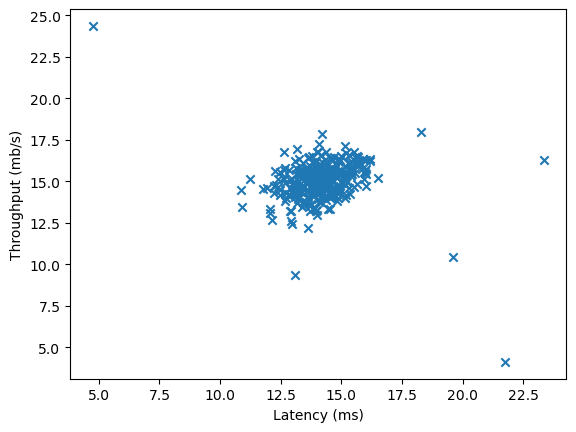

mu =  [14.11222578 14.99771051] 
sigma =  [1.83263141 1.70974533]
p =  (307,) 1.1812091168967526e-23 0.08986095083415364
Z =  (71, 71) 2.7743417539960682e-104 0.08960327031879418


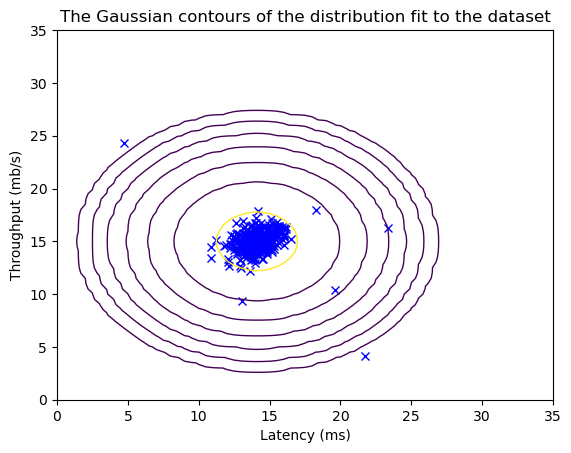

In [29]:

import numpy as np

def estimate_gaussian(X):
    """
    Estimate the parameters of a Gaussian distribution using the data in X (m x n)
    param X: The dataset with shape (m, n)
    return: The mean and variance of the data
    """
    m, n = X.shape
    mu = np.zeros(n)
    sigma2 = np.zeros(n)
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2

def multivariate_gaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution(multivariate means multiple features).
    param X: The dataset with shape (m, n)
    param mu: The mean of the dataset with shape (n, )
    param sigma2: The variances of the dataset with shape (n, )
    return: The probability density function of the examples X under the multivariate gaussian distribution with parameters mu and sigma2.
    """
    k = len(mu)
    sigma2 = np.diag(sigma2)
    X = X - mu
    p = (2*np.pi)**(-k/2) * np.linalg.det(sigma2)**(-0.5) * np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(sigma2)) * X, axis=1))
    return p

X_train = np.load('datasets/X_part1.npy')
print("X_train = ", X_train.shape)
# plot
import matplotlib.pyplot as plt
plt.scatter(X_train[:,0], X_train[:,1], marker='x')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

mu , var = estimate_gaussian(X_train)
print("mu = ", mu, "\nsigma = ", var)

p =  multivariate_gaussian(X_train, mu, var)
print("p = ", p.shape,np.min(p),np.max(p))

# plot
X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
Z = multivariate_gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, var)
Z = Z.reshape(X1.shape)

plt.plot(X_train[:, 0], X_train[:, 1], 'bx')
print("Z = ", Z.shape,np.min(Z),np.max(Z))
if np.sum(np.isinf(Z)) == 0:
    plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), linewidths=1)
    
# Set the title
plt.title("The Gaussian contours of the distribution fit to the dataset")
# Set the y-axis label
plt.ylabel('Throughput (mb/s)')
# Set the x-axis label
plt.xlabel('Latency (ms)')

# define epsilon and F1 score

def select_threshold(pval, yval):
    """
    Find the best threshold (epsilon) to use for selecting outliers based on the results from a validation set and the ground truth.
    param pval: The p-values for the validation set examples. Shape (m, )
    param yval: The ground truth for the validation set examples. Shape (m, )
    return: The best threshold (epsilon)
    """
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    stepsize = (max(pval) - min(pval)) / 1000
    for epsilon in np.arange(min(pval), max(pval), stepsize):
        predictions = (pval < epsilon)
        tp = np.sum((predictions == 1) & (yval == 1))
        fp = np.sum((predictions == 1) & (yval == 0))
        fn = np.sum((predictions == 0) & (yval == 1))
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        f1 = (2 * prec * rec) / (prec + rec)
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    return best_epsilon, best_f1






**anamoly detection**

equation for Calculate the responsibilities : 
derivation of equation for Calculate the responsibilities :

$ r_{ik}$ = probability that example $x^{(i)}$ belongs to cluster $k$ given by:

$$ r_{ik} = \frac{\pi_k N(x_i | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j N(x_i | \mu_j, \Sigma_j)} $$
N(x_i | \mu_k, \Sigma_k) = probability density function of multivariate normal distribution
$$ N(x_i | \mu_k, \Sigma_k) = \frac{1}{(2\pi)^{D/2}|\Sigma_k|^{1/2}} \exp \left( -\frac{1}{2} (x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k) \right) $$
$$ \pi_k = \frac{N_k}{N} $$
$$ \mu_k = \frac{1}{N_k} \sum_{i=1}^N r_{ik} x_i $$
$$ \Sigma_k = \frac{1}{N_k} \sum_{i=1}^N r_{ik} (x_i - \mu_k)(x_i - \mu_k)^T $$

where
- $N_k$ = total number of points assigned to cluster $k$
- $N$ = total number of points
- $D$ = dimension of the data
- $\pi_k$ = prior probability of cluster $k$
- $\mu_k$ = mean of cluster $k$
- $\Sigma_k$ = covariance matrix of cluster $k$

derivation of equation for Calculate the responsibilities :
$$ \ln p(X | \pi, \mu, \Sigma) = \sum_{n=1}^N \ln \left\{ \sum_{k=1}^K \pi_k N(x_n | \mu_k, \Sigma_k) \right\} $$
$$ \ln p(X | \pi, \mu, \Sigma) = \sum_{n=1}^N \ln \left\{ \sum_{k=1}^K \pi_k \frac{1}{(2\pi)^{D/2}|\Sigma_k|^{1/2}} \exp \left( -\frac{1}{2} (x_n - \mu_k)^T \Sigma_k^{-1} (x_n - \mu_k) \right) \right\} $$

equation for Update the parameters : $$ \mu_k = \frac{1}{N_k} \sum_{i=1}^N r_{ik} x_i $$
equation for Update the parameters : $$ \Sigma_k = \frac{1}{N_k} \sum_{i=1}^N r_{ik} (x_i - \mu_k)(x_i - \mu_k)^T $$
equation for Update the parameters : $$ \pi_k = \frac{N_k}{N} $$
equation for Calculate the log-likelihood : $$ \ln p(X | \pi, \mu, \Sigma) = \sum_{n=1}^N \ln \left\{ \sum_{k=1}^K \pi_k N(x_n | \mu_k, \Sigma_k) \right\} $$
equation for Check for convergence : $$ \ln p(X | \pi, \mu, \Sigma) $$ 

whole architecture pseudo code:
1. Initialize the means and covariances randomly

for iteration in range(max_iters):
    2. E-step: Calculate the responsibilities 
    $$ r_{ik} = \frac{\pi_k N(x_i | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j N(x_i | \mu_j, \Sigma_j)} $$
    $$ \mu_k = \frac{1}{N_k} \sum_{i=1}^N r_{ik} x_i $$
    $$ \Sigma_k = \frac{1}{N_k} \sum_{i=1}^N r_{ik} (x_i - \mu_k)(x_i - \mu_k)^T $$
    $$ \pi_k = \frac{N_k}{N} $$
    $$ \ln p(X | \pi, \mu, \Sigma) = \sum_{n=1}^N \ln \left\{ \sum_{k=1}^K \pi_k N(x_n | \mu_k, \Sigma_k) \right\} $$
    $$ \ln p(X | \pi, \mu, \Sigma) $$
    3. M-step: Update the parameters
    4. Calculate the log-likelihood
    5. Check for convergence
return means, covariances, weights


X_train =  (307, 2)


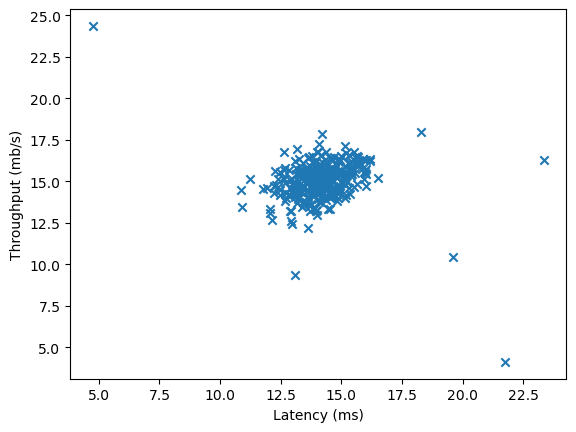

means =  (3, 2) 
covariances =  (3, 2, 2) 
weights =  (3,)


/var/folders/y5/h2k1t0890tnd6v8vkfcpt3jw0000gn/T/ipykernel_7609/3913247221.py:43: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_likelihood = np.sum(np.log(np.sum(weights[i] * multivariate_normal_pdf(data, means[i], covariances[i]) for i in range(n_components))))


LinAlgError: Singular matrix

In [31]:

def initialize_parameters(data, n_components):
    # Initialize the means and covariances randomly
    n_samples, n_features = data.shape
    np.random.seed(0)
    means = np.random.randn(n_components, n_features)
    covariances = np.zeros((n_components, n_features, n_features))
    for i in range(n_components):
        covariances[i] = np.eye(n_features)
    weights = np.ones(n_components) / n_components
    return means, covariances, weights

def multivariate_normal_pdf(data, mean, covariance):
    """
    equation : $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$
    param data: The dataset with shape (m, n)
    param mean: The mean of the dataset with shape (n, )
    param covariance: The covariance of the dataset with shape (n, n)
    return: The probability density function of the examples X under the multivariate gaussian distribution with parameters mu and sigma2.

    """
    n_features = data.shape[1]
    det = np.linalg.det(covariance)
    inv = np.linalg.inv(covariance)
    diff = data - mean
    exponent = np.sum(-0.5 * (diff @ inv * diff), axis=1)
    pdf = (1.0 / (np.sqrt((2 * np.pi) ** n_features * det))) * np.exp(exponent)
    return pdf

def expectation_maximization(data, n_components, max_iters=100, tol=1e-4):
    """

    """
    n_samples = data.shape[0]
    means, covariances, weights = initialize_parameters(data, n_components)
    print("means = ", means.shape, "\ncovariances = ", covariances.shape, "\nweights = ", weights.shape)
    prev_log_likelihood = None

    for iteration in range(max_iters):
        # E-step: Calculate the responsibilities
        responsibilities = np.zeros((n_samples, n_components))
        for i in range(n_components):
            responsibilities[:, i] = weights[i] * multivariate_normal_pdf(data, means[i], covariances[i])
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

        # M-step: Update the parameters
        Nk = np.sum(responsibilities, axis=0)
        weights = Nk / n_samples
        means = (responsibilities.T @ data) / Nk[:, np.newaxis]
        for i in range(n_components):
            diff = data - means[i]
            covariances[i] = (responsibilities[:, i, np.newaxis] * diff).T @ diff / Nk[i]

        # Calculate the log-likelihood
        log_likelihood = np.sum(np.log(np.sum(weights[i] * multivariate_normal_pdf(data, means[i], covariances[i]) for i in range(n_components))))
        
        # Check for convergence
        if prev_log_likelihood is not None and np.abs(log_likelihood - prev_log_likelihood) < tol:
            break
        
        prev_log_likelihood = log_likelihood

    return means, covariances, weights

def anomaly_detection(data, means, covariances, weights, threshold):
    pdf_values = np.sum(weights[i] * multivariate_normal_pdf(data, means[i], covariances[i]) for i in range(len(weights)))
    anomalies = data[pdf_values < threshold]
    return anomalies

data = np.load('datasets/X_part1.npy')
print("X_train = ", X_train.shape)
normal_x, normal_y = data[:, 0], data[:, 1]
# plot
import matplotlib.pyplot as plt
plt.scatter(data[:,0], data[:,1], marker='x')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()


# Fit a GMM to the data
n_components = 3 # You may need to change this to get a good fit for the data above 
means, covariances, weights = expectation_maximization(data, n_components)
# Set a threshold (you may need to fine-tune this)
threshold = 0.1
# Detect anomalies
anomalies = anomaly_detection(data, means, covariances, weights, threshold)
print("Detected Anomalies:")
print(anomalies,anomalies.shape)
# Separate detected anomalies for plotting
anomalies_x, anomalies_y = anomalies[:, 0], anomalies[:, 1]

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(normal_x, normal_y, label='Normal Data', s=10)
# plt.scatter(anomalous_x, anomalous_y, label='Anomalous Data', s=20, c='red', marker='x')
plt.scatter(anomalies_x, anomalies_y, label='Detected Anomalies', s=50, edgecolor='orange', facecolor='none', marker='o', linewidth=2)
plt.title('Scatter Plot of Normal and Anomalous Data with Detected Anomalies')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

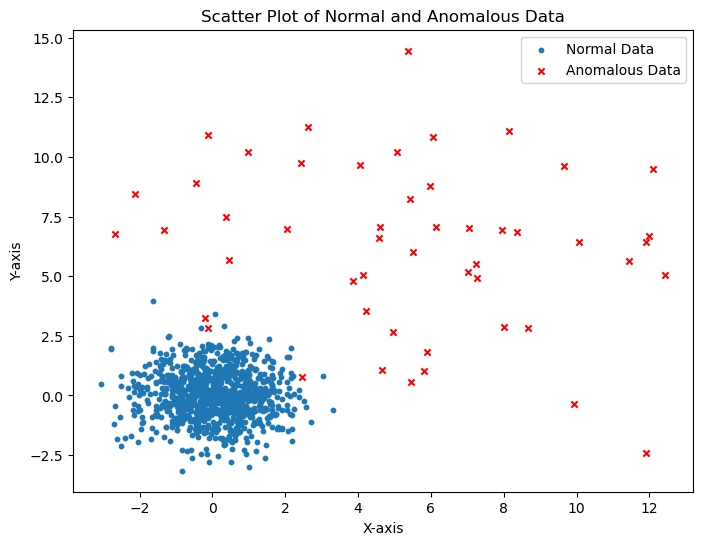

Detected Anomalies:
(54, 2)


/var/folders/y5/h2k1t0890tnd6v8vkfcpt3jw0000gn/T/ipykernel_7609/2108208147.py:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_likelihood = np.sum(np.log(np.sum(weights[i] * multivariate_normal_pdf(data, means[i], covariances[i]) for i in range(n_components))))
/var/folders/y5/h2k1t0890tnd6v8vkfcpt3jw0000gn/T/ipykernel_7609/2108208147.py:55: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  pdf_values = np.sum(weights[i] * multivariate_normal_pdf(data, means[i], covariances[i]) for i in range(len(weights)))


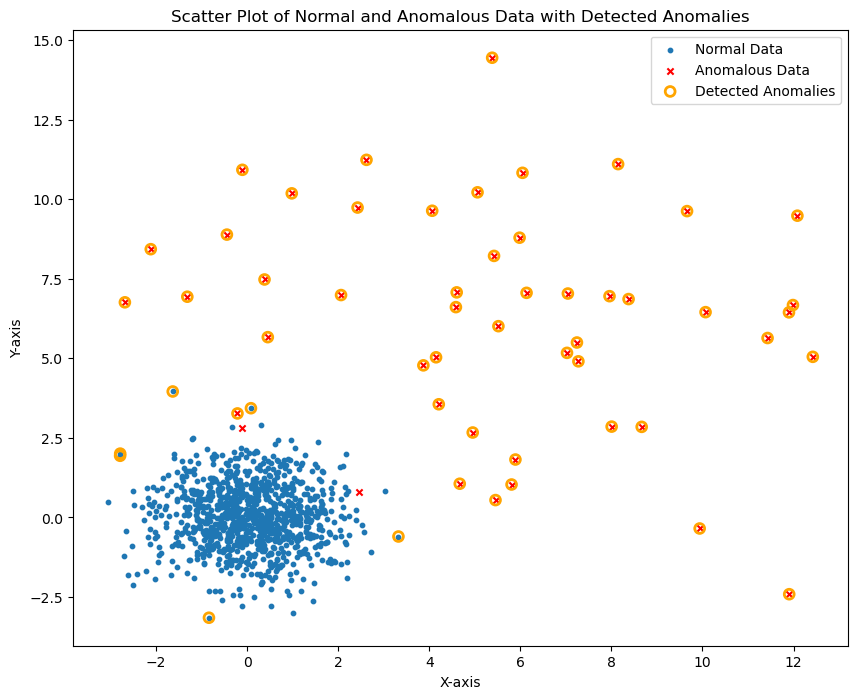

In [19]:
import numpy as np

def initialize_parameters(data, n_components):
    # Initialize the means and covariances randomly
    n_samples, n_features = data.shape
    np.random.seed(0)
    means = np.random.randn(n_components, n_features)
    covariances = np.zeros((n_components, n_features, n_features))
    for i in range(n_components):
        covariances[i] = np.eye(n_features)
    weights = np.ones(n_components) / n_components
    return means, covariances, weights

def multivariate_normal_pdf(data, mean, covariance):
    n_features = data.shape[1]
    det = np.linalg.det(covariance)
    inv = np.linalg.inv(covariance)
    diff = data - mean
    exponent = np.sum(-0.5 * (diff @ inv * diff), axis=1)
    pdf = (1.0 / (np.sqrt((2 * np.pi) ** n_features * det))) * np.exp(exponent)
    return pdf

def expectation_maximization(data, n_components, max_iters=100, tol=1e-4):
    n_samples = data.shape[0]
    means, covariances, weights = initialize_parameters(data, n_components)
    prev_log_likelihood = None

    for iteration in range(max_iters):
        # E-step: Calculate the responsibilities
        responsibilities = np.zeros((n_samples, n_components))
        for i in range(n_components):
            responsibilities[:, i] = weights[i] * multivariate_normal_pdf(data, means[i], covariances[i])
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

        # M-step: Update the parameters
        Nk = np.sum(responsibilities, axis=0)
        weights = Nk / n_samples
        means = (responsibilities.T @ data) / Nk[:, np.newaxis]
        for i in range(n_components):
            diff = data - means[i]
            covariances[i] = (responsibilities[:, i, np.newaxis] * diff).T @ diff / Nk[i]

        # Calculate the log-likelihood
        log_likelihood = np.sum(np.log(np.sum(weights[i] * multivariate_normal_pdf(data, means[i], covariances[i]) for i in range(n_components))))
        
        # Check for convergence
        if prev_log_likelihood is not None and np.abs(log_likelihood - prev_log_likelihood) < tol:
            break
        
        prev_log_likelihood = log_likelihood

    return means, covariances, weights

def anomaly_detection(data, means, covariances, weights, threshold):
    pdf_values = np.sum(weights[i] * multivariate_normal_pdf(data, means[i], covariances[i]) for i in range(len(weights)))
    anomalies = data[pdf_values < threshold]
    return anomalies


# Generate some example data
np.random.seed(1)
normal_data = np.random.randn(1000, 2)
anomalous_data = np.random.randn(50, 2) * 4 + [6, 6]
data = np.vstack([normal_data, anomalous_data])

# Separate normal and anomalous data for plotting
normal_x, normal_y = normal_data[:, 0], normal_data[:, 1]
anomalous_x, anomalous_y = anomalous_data[:, 0], anomalous_data[:, 1]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(normal_x, normal_y, label='Normal Data', s=10)
plt.scatter(anomalous_x, anomalous_y, label='Anomalous Data', s=20, c='red', marker='x')
plt.title('Scatter Plot of Normal and Anomalous Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

# Fit a GMM to the data
n_components = 6 # You may need to change this to get a good fit for the data above 
means, covariances, weights = expectation_maximization(data, n_components)
# Set a threshold (you may need to fine-tune this)
threshold = 0.001
# Detect anomalies
anomalies = anomaly_detection(data, means, covariances, weights, threshold)
print("Detected Anomalies:")
print(anomalies.shape)
# Separate detected anomalies for plotting
anomalies_x, anomalies_y = anomalies[:, 0], anomalies[:, 1]

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(normal_x, normal_y, label='Normal Data', s=10)
plt.scatter(anomalous_x, anomalous_y, label='Anomalous Data', s=20, c='red', marker='x')
plt.scatter(anomalies_x, anomalies_y, label='Detected Anomalies', s=50, edgecolor='orange', facecolor='none', marker='o', linewidth=2)
plt.title('Scatter Plot of Normal and Anomalous Data with Detected Anomalies')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

